In [1]:
import os
import re
import copy
from pathlib import Path
from test_setup import *
from recurrent_network import *

In [2]:
dir_path    = Path(os.getcwd()).parent.resolve()

In [4]:
with open(dir_path / "data/little-fish.txt") as f:
    text = f.read().lower()

In [8]:
# Encode Text as One-Hot Vectors
def one_hot(key, token_map):
    vec = [0] * vocab_size
    vec[token_map[key]] = 1
    return vec

In [5]:
# Split sentences using punctuation marks that end sentences
splits   = re.split(r"[.!?]+", text)

# Clean each sentence
sentences   = []
for s in splits:
    s   = s.strip()
    if not s:
        continue
    s   = re.sub(r"[^a-zA-Z0-9'\s]", '', s)  # keep only letters, numbers, apostrophes, and spaces
    sentences.append(s.lower())

## RNN Model

DISCLAIMER: Below this model, there are two training blocks. Only run a single training block for each results evaluation.

In [9]:
rnn = RecurrentNetwork(
    layer_sizes=[vocab_size, 32, vocab_size],
    active=Activation.relu,
    learn=LearningRule.gradient,
    loss="cross-entropy",
    random_seed=42
)

In [12]:
cycle_error = []

In [3]:
def mse(y_true, y_pred, n):
    result = 0
    for i in range(len(y_true)):
        result += (y_true[i] - y_pred[i])**2

    return result/n

### Training A: Character Level Tokens

In [ ]:
min_loss    = float('inf')
best_model  = copy.deepcopy(rnn)

# Get unique characters
vocab = sorted(set(" ".join(sentences)))
vocab_size = len(vocab)

# Character to token level map
char_to_idx = {c: i for i, c in enumerate(vocab)}
idx_to_char = {i: c for i, c in enumerate(vocab)}

# Character Level: Only run if 
sequence = [one_hot(char, char_to_idx) for char in text]

# TRAINING
for epoch in range(500):
    total_loss = 0
    for i in range(len(sequence)-1):
        x = sequence[i]         # input char one-hot
        y_true = sequence[i+1]  # next char one-hot

        rnn.train(x, y_true, 0.005, 0.9)
        y_pred  = rnn.predict(x)
        total_loss += mse(y_true, y_pred, len(y_true))

    # Store the best model for later
    if total_loss < min_loss:
        min_loss    = total_loss
        best_model  = copy.deepcopy(rnn)

    # Add cycle error to history
    cycle_error.append(total_loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss {total_loss}")

### Training B: Word Level Tokens

In [13]:
min_loss    = float('inf')
best_model  = copy.deepcopy(rnn)

# Get unique words
vocab = sorted(set(" ".join(sentences).split()))
vocab_size = len(vocab)

# Word token level map
word_to_idx = {c: i for i, c in enumerate(vocab)}
idx_to_word = {i: c for i, c in enumerate(vocab)}

# Word token input sequences for each sentence in the text
sequence = [[one_hot(word, word_to_idx) for word in sentence.split()] for sentence in sentences]

# TRAINING
for epoch in range(500):
    total_loss = 0
    for sentence in sequence:
        for w, word in enumerate(sentence[:-1]):
            x       = sentence[w]
            y_true  = sentence[w+1]

            rnn.train(x, y_true, 0.005, 0.9)  # you’d need a train method using BPTT
            
        y_pred  = rnn.predict(x)
        total_loss += mse(y_true, y_pred, len(y_true))

        # Store the best model for later
        if total_loss < min_loss:
            min_loss    = total_loss
            best_model  = copy.deepcopy(rnn)

    # Add cycle error to history
    cycle_error.append(total_loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss {total_loss}")

Epoch 0, Loss 0.19888052464997252
Epoch 100, Loss 0.09781877967912687
Epoch 200, Loss 0.09278820517150559
Epoch 300, Loss 0.09394287798635698
Epoch 400, Loss 0.09502042458458178


In [15]:
# Suppose your text and vocab setup are already done
seed_words = ["he", "swam", "away", "and", "thought"]
seed_sequence = [one_hot(key, word_to_idx) for key in seed_words]

# Predict next 5 words
n_next = 3
best_sequence       = best_model.predict_next(seed_sequence, n_next)
predicted_sequence  = rnn.predict_next(seed_sequence, n_next)

# Convert predictions back to words (take argmax)
best_words = []
for out in best_sequence[len(seed_sequence):]:  # only the new predictions
    idx = out.index(max(out))
    best_words.append(idx_to_word[idx])

# Convert predictions back to words (take argmax)
predicted_words = []
for out in predicted_sequence[len(seed_sequence):]:  # only the new predictions
    idx = out.index(max(out))
    predicted_words.append(idx_to_word[idx])


print("Best next words:", " ".join(best_words))
print("Predicted next words:", " ".join(predicted_words))

Best next words: of a little
Predicted next words: of a little


In [16]:
import matplotlib.pyplot as plt

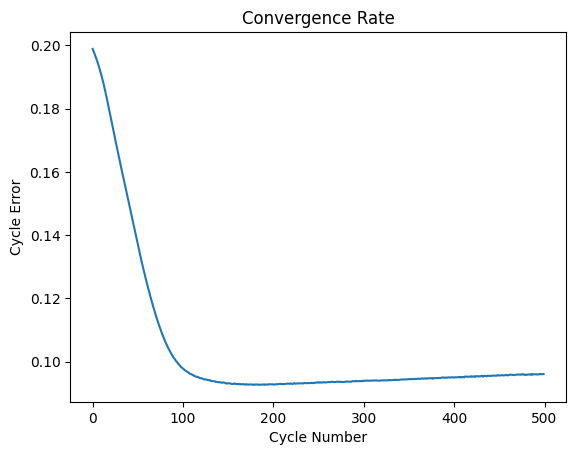

In [17]:
plt.plot(cycle_error)
plt.title("Convergence Rate")
plt.xlabel("Cycle Number")
plt.ylabel("Cycle Error")
plt.show()

In [18]:
import pickle

In [19]:
bm_handle = open(dir_path / "models/lf-bm-epoch500", "wb")
pickle.dump(best_model, bm_handle)
bm_handle.close()

fm_handle = open(dir_path / "models/lf-fm-epoch500", "wb")
pickle.dump(best_model, fm_handle)
fm_handle.close()